In [4]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import observefunc as obs

# Analyse NCDF

In [6]:
#folder= "/home/peter/EasterIslands/Code/Full_Model/#Figs/FullModel_grid50_repr0,07_06Apr/"
#folder = "/home/peter/EasterIslands/Code/Full_Model/Figs/FullModel_grid50_repr0,007_Standard/"
folder = "/home/peter/EasterIslands/Code/Full_Model/Figs/FullModel_grid50_repr7e-03_mv8_Standard/"
folder="/home/peter/EasterIslands/Code/Full_Model/Figs/Test/FullModel_grid20_repr3e-02_mv8_Standard/"#/Statistics.ncdf
folder="/home/peter/EasterIslands/Code/Full_Model/Figs_WithDrought/FullModel_grid50_repr7e-03_mv10_Standard/"#Statistics.ncdf"

In [7]:
data = xr.open_dataset(folder+"Statistics.ncdf")
data

<xarray.Dataset>
Dimensions:              (2d: 2, index: 1440, time: 1051, triangles: 2768)
Coordinates:
  * time                 (time) int64 800 801 802 803 ... 1847 1848 1849 1850
  * index                (index) int64 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
  * triangles            (triangles) int64 0 1 2 3 4 ... 2764 2765 2766 2767
  * 2d                   (2d) object 'x' 'y'
Data variables:
    total_agents         (time) int64 ...
    total_population     (time) int64 ...
    total_deaths         (time) int64 ...
    total_trees          (time) int64 ...
    tree_density         (triangles, time) float64 ...
    agriculture          (triangles, time) float64 ...
    populationOccupancy  (triangles, time) float64 ...
    happyFraction        (time) float64 ...
    SizeAgents           (index, time) float64 ...
    PosAgents            (index, 2d, time) float64 ...
    Penalty_Mean         (time) float64 ...
    Penalty_Std          (time) float64 ...
    FishersPop           (ti

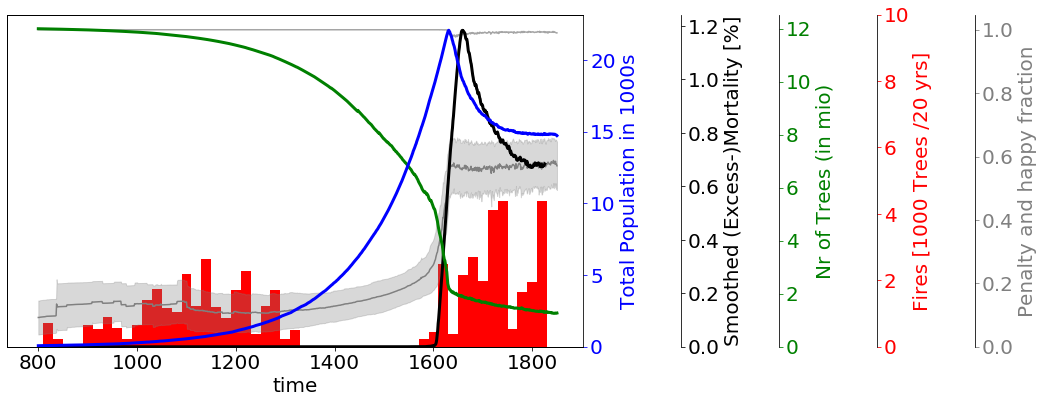

In [8]:
def plot_statistics(data, folder):
    fig = plt.figure(figsize=(20,6))
    rcParams = {'font.size':20}
    plt.rcParams.update(rcParams)
    #ax1.spines["right"].set_position(('axes',1.0))

    colors=["blue", "k", "green", "red", "gray"]


    ax = []
    ax.append(fig.add_subplot(111))
    for i in range(4):
        ax.append(ax[0].twinx())


    (1e-3 * data.total_population).plot(ax=ax[0],lw=3, color=colors[0])
    ax[0].set_ylabel("Total Population in 1000s")

    mortality = data.total_deaths/data.total_population
    N=50
    mortality_smoothed = np.convolve(mortality, np.ones((N,))/N, mode='valid')
    time_smoothed = np.convolve(data.time, np.ones((N,))/N, mode='valid')
    ax[1].plot(time_smoothed, mortality_smoothed*100, color=colors[1], lw=3)
    ax[1].set_ylabel("Smoothed (Excess-)Mortality [%]")

    (data.total_trees*1e-6).plot(ax=ax[2],color=colors[2], lw=3)
    ax[2].set_ylabel("Nr of Trees (in mio)")

    fireSize = np.zeros(len(data.time))
    fireSize[data.firesTime- data.isel(time=0).time.values] += data.firesSize
    t0=data.isel(time=0).time.values
    BINwidth=20
    bins = np.arange(t0, data.isel(time=-1).time+1, step=BINwidth )
    binned_fireSize = [1e-3 * np.sum( fireSize[( bins[k]-t0)  :  (bins[k+1]-t0 )]) for k in range(len(bins)-1)]
    ax[3].bar(bins[:-1], binned_fireSize,color=colors[3], width=BINwidth)#, bins=np.arange(data.time[0],data.time[-1]+1, step=20), alpha=1, color=colors[3])
    ax[3].set_ylabel("Fires [1000 Trees /"+str(BINwidth)+" yrs]")

    data.happyFraction.plot(ax=ax[4],color=colors[4], alpha=0.7)
    plt.fill_between(data.time, data.Penalty_Mean-data.Penalty_Std, data.Penalty_Mean+data.Penalty_Std, color=colors[4], alpha=0.3)
    data.Penalty_Mean.plot(ax=ax[4], color=colors[4], alpha=1)
    ax[4].set_ylabel("Penalty and happy fraction")



    for i,a in enumerate(ax):
        #a.spines["right"].set_position(('axes',1.0))
        a.tick_params(axis="y", colors=colors[i])
        a.spines["right"].set_position(("axes", 1+(i)*0.17))
        #a.set_ylabel(["R", "L", "E", "V"][i])
        a.yaxis.label.set_color(colors[i])
        a.set_ylim(0,)
        a.yaxis.set_label_position("right")
        a.yaxis.tick_right()

    ax[3].set_ylim(0,10)

    ax[3].set_zorder(ax[0].get_zorder()) 
    ax[4].set_zorder(ax[3].get_zorder()+1)
    ax[4].patch.set_visible(False)
    ax[1].set_zorder(ax[4].get_zorder()+1)
    ax[1].patch.set_visible(False)
    ax[2].set_zorder(ax[1].get_zorder()+1)
    ax[2].patch.set_visible(False)
    ax[0].set_zorder(ax[2].get_zorder()+1)
    ax[0].patch.set_visible(False)
    fig.tight_layout()
    plt.savefig(folder+"Statistics_timeseries.svg")


In [65]:
fireSize = np.zeros(len(data.time))
fireSize[data.firesTime- data.isel(time=0).time.values] += data.firesSize
fireSize[( bins[k]-data.isel(time=0).time.values)  :  (bins[k+1]-data.isel(time=0).time.values) ]

array([ 35., 110.,  32., 268., 202., 165., 106.,   0.,   0., 263.])

# MAP

In [12]:
import pickle
import config
from pathlib import Path   # for creating a new directory
filename = "Map/EI_grid"+str(data.gridpoints_y)+"_rad"+str(data.tree_search_radius)+"+"+str(data.agriculture_radius)
if Path(filename).is_file():
    with open(filename, "rb") as EIfile:
        config.EI = pickle.load(EIfile)
from observefunc import observe_density


In [13]:
def get_fires_in_t(t_0, t_1):
    fires_points=[]
    n=0
    while data.firesTime[n]<t_0:
        n+=1
    while data.firesTime[n]<t_1 and data.firesTime[n]>=t_0:
    #inds = np.where(data.firesTime==t)[0]
    #for n in inds:
        loc = config.EI.EI_midpoints[int(data.firesLoc[n])]
        fires_points.append([loc[0], loc[1], data.firesSize[n]])
        n+=1
    fires_points=np.array(fires_points)
    return fires_points


In [14]:
fires_points = get_fires_in_t(1100,1200)

(array([3., 2., 0., 1., 3., 2., 4., 4., 3., 5.]),
 array([ 64. , 103.9, 143.8, 183.7, 223.6, 263.5, 303.4, 343.3, 383.2,
        423.1, 463. ]),
 <a list of 10 Patch objects>)

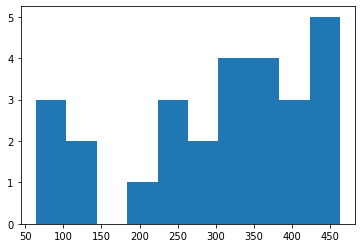

In [15]:
plt.hist(fires_points[:,2])

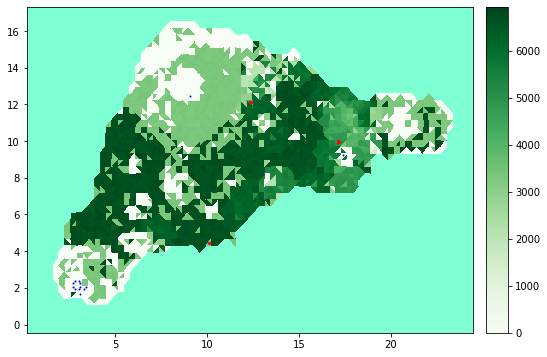

In [16]:
times_to_plot = np.arange(1200,1210,step=10)
for t in times_to_plot:
    fires_points = get_fires_in_t(t-10, t)
    config.EI.tree_density = data.tree_density.sel(time=t)
    fig, ax = config.EI.plot_TreeMap_and_hist()
    
    plot = ax.scatter(fires_points[:,0], config.EI.corners['upper_left'][1] - fires_points[:,1], s=10*fires_points[:,2]/max(fires_points[:,2]), color='red')


In [ ]:
times_to_plot = np.arange(1200,1210,step=10)

times_to_plot

In [45]:
fires_points

array([[ 15.79083688,   4.18971373, 229.        ],
       [ 15.79083688,   4.18971373, 228.        ],
       [ 15.79083688,   4.18971373, 213.        ],
       ...,
       [  5.33474219,  11.25237403, 127.        ],
       [  3.62762469,  11.97061067, 317.        ],
       [  3.73431953,  12.32972899, 381.        ]])

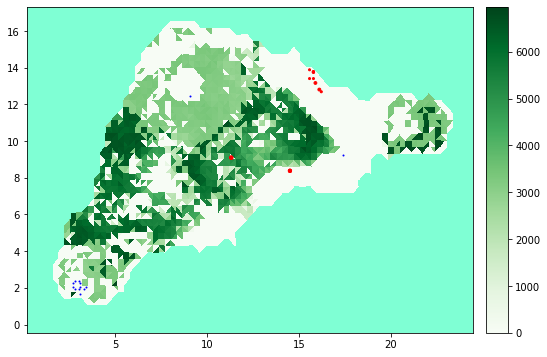

In [56]:
fires_points[:,2]/max(fires_points[:,2])

array([0.48516949, 0.48305085, 0.45127119, 0.48305085, 0.47033898,
       0.40466102, 0.79025424, 0.81144068, 1.        , 1.        ,
       1.        , 1.        , 0.09957627, 0.39830508, 0.40677966,
       0.9809322 , 0.99576271, 0.4279661 ])

# CHECK KTH RUNS


In [7]:
folder = "/home/peter/EasterIslands/Code/Full_Model/KTHruns/FullModel_grid50_repr7e-03_mv12_Standard_seed31/"
file = folder+"Statistics.ncdf"
data = xr.open_dataset(file)

In [9]:
obs.plot_statistics(data, folder)

In [10]:
data

<xarray.Dataset>
Dimensions:              (2d: 2, index: 2554, time: 1101, triangles: 2768)
Coordinates:
  * index                (index) int64 0 1 2 3 4 5 ... 2549 2550 2551 2552 2553
  * triangles            (triangles) int64 0 1 2 3 4 ... 2764 2765 2766 2767
  * 2d                   (2d) object 'x' 'y'
  * time                 (time) int64 800 801 802 803 ... 1897 1898 1899 1900
Data variables:
    Penalty_Std          (time) float64 ...
    Fraction_eroded      (time) float64 ...
    FishersPop           (time) float64 ...
    tree_density         (triangles, time) float64 ...
    Penalty_Mean         (time) float64 ...
    SizeAgents           (index, time) float64 ...
    total_deaths         (time) int64 ...
    agriculture          (triangles, time) float64 ...
    populationOccupancy  (triangles, time) float64 ...
    total_population     (time) int64 77 77 77 78 81 ... 18086 18194 18202 17977
    total_trees          (time) int64 11999700 11999392 ... 1284691 1240731
    PosA

In [14]:
data.firesSize.min()

-6406

In [15]:
data.total_trees.sel(time=1450)

<xarray.DataArray 'total_trees' ()>
array(8460146)
Coordinates:
    time     int64 1450